## Кредитный скоринг - блокнот с анализом данных

### Необходимые импорты

In [1]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Переменные

In [2]:
# ---------- DATA ----------
TRAIN_DATA_DIR = "./train_data" #Директория с train датой
TEST_DATA_DIR = "./test_data" #Директория с test датой

TRAIN_TARGET = './train_target.csv' # ID и Метки классов
TEST_TARGET = './test_target.csv' # ID для кого определить веротяности


RANDOM_STATE = 42

### Загрузка данных и EDA
(Все не помещается)


Особенности:
1. Большой дисбаланс классов (2.8kk, 100k)
2. Разные длины взаимодействий (rn)
3. Есть коррелированные признаки
4. Файлы с датой ровно разделены по ID-шникам, что упрощает анализ (скорей всего не получится, что клиент с одним ID-шником раскинут по разным файлам)

In [3]:
all_files_data = os.listdir(TRAIN_DATA_DIR)
assert len(all_files_data) == 12, "req 12 data files"

In [4]:
all_df = []
corr_matrix_name = {} #Словарь с корреляционными матрицами

#Список id и соответствующими длиннами историй
idx_to_hisLen = []


for filename in all_files_data:
    tmp_df = pd.read_parquet(f'{TRAIN_DATA_DIR}/{filename}')

    tmp_group = tmp_df.groupby('id')['rn'].count()
    idx_to_hisLen.append(tmp_group)

    #Формируем матрицу корреляций
    # corr_matrx = tmp_df.corr()
    # corr_matrix_name[filename] = corr_matrx
    
    print(
        f"NAME: {filename}",
        f"SAHPE: {tmp_df.shape}", #Форма
        f"MIN_ID: {tmp_df['id'].min()}", #Минимальный ID
        f"MAX_ID: {tmp_df['id'].max()}", #Максимальный ID
        "------------",
        sep="\n"
    )

    #Неободимо посчитать, размер историй для каждого класса и построить распределения
    # all_df.append(tmp_df)

# frame = pd.concat(all_df, ignore_index=True)

NAME: train_data_0.pq
SAHPE: (1974724, 59)
MIN_ID: 0
MAX_ID: 249999
------------
NAME: train_data_1.pq
SAHPE: (2107305, 59)
MIN_ID: 250000
MAX_ID: 499999
------------
NAME: train_data_10.pq
SAHPE: (2296372, 59)
MIN_ID: 2500000
MAX_ID: 2749999
------------
NAME: train_data_11.pq
SAHPE: (2450630, 59)
MIN_ID: 2750000
MAX_ID: 2999999
------------
NAME: train_data_2.pq
SAHPE: (2080508, 59)
MIN_ID: 500000
MAX_ID: 749999
------------
NAME: train_data_3.pq
SAHPE: (2112592, 59)
MIN_ID: 750000
MAX_ID: 999999
------------
NAME: train_data_4.pq
SAHPE: (2064110, 59)
MIN_ID: 1000000
MAX_ID: 1249999
------------
NAME: train_data_5.pq
SAHPE: (2150908, 59)
MIN_ID: 1250000
MAX_ID: 1499999
------------
NAME: train_data_6.pq
SAHPE: (2176452, 59)
MIN_ID: 1500000
MAX_ID: 1749999
------------
NAME: train_data_7.pq
SAHPE: (2222245, 59)
MIN_ID: 1750000
MAX_ID: 1999999
------------
NAME: train_data_8.pq
SAHPE: (2242615, 59)
MIN_ID: 2000000
MAX_ID: 2249999
------------
NAME: train_data_9.pq
SAHPE: (2284256, 59)


#### Матрицы корреляций

In [5]:
corr_matrix_name.keys()

dict_keys([])

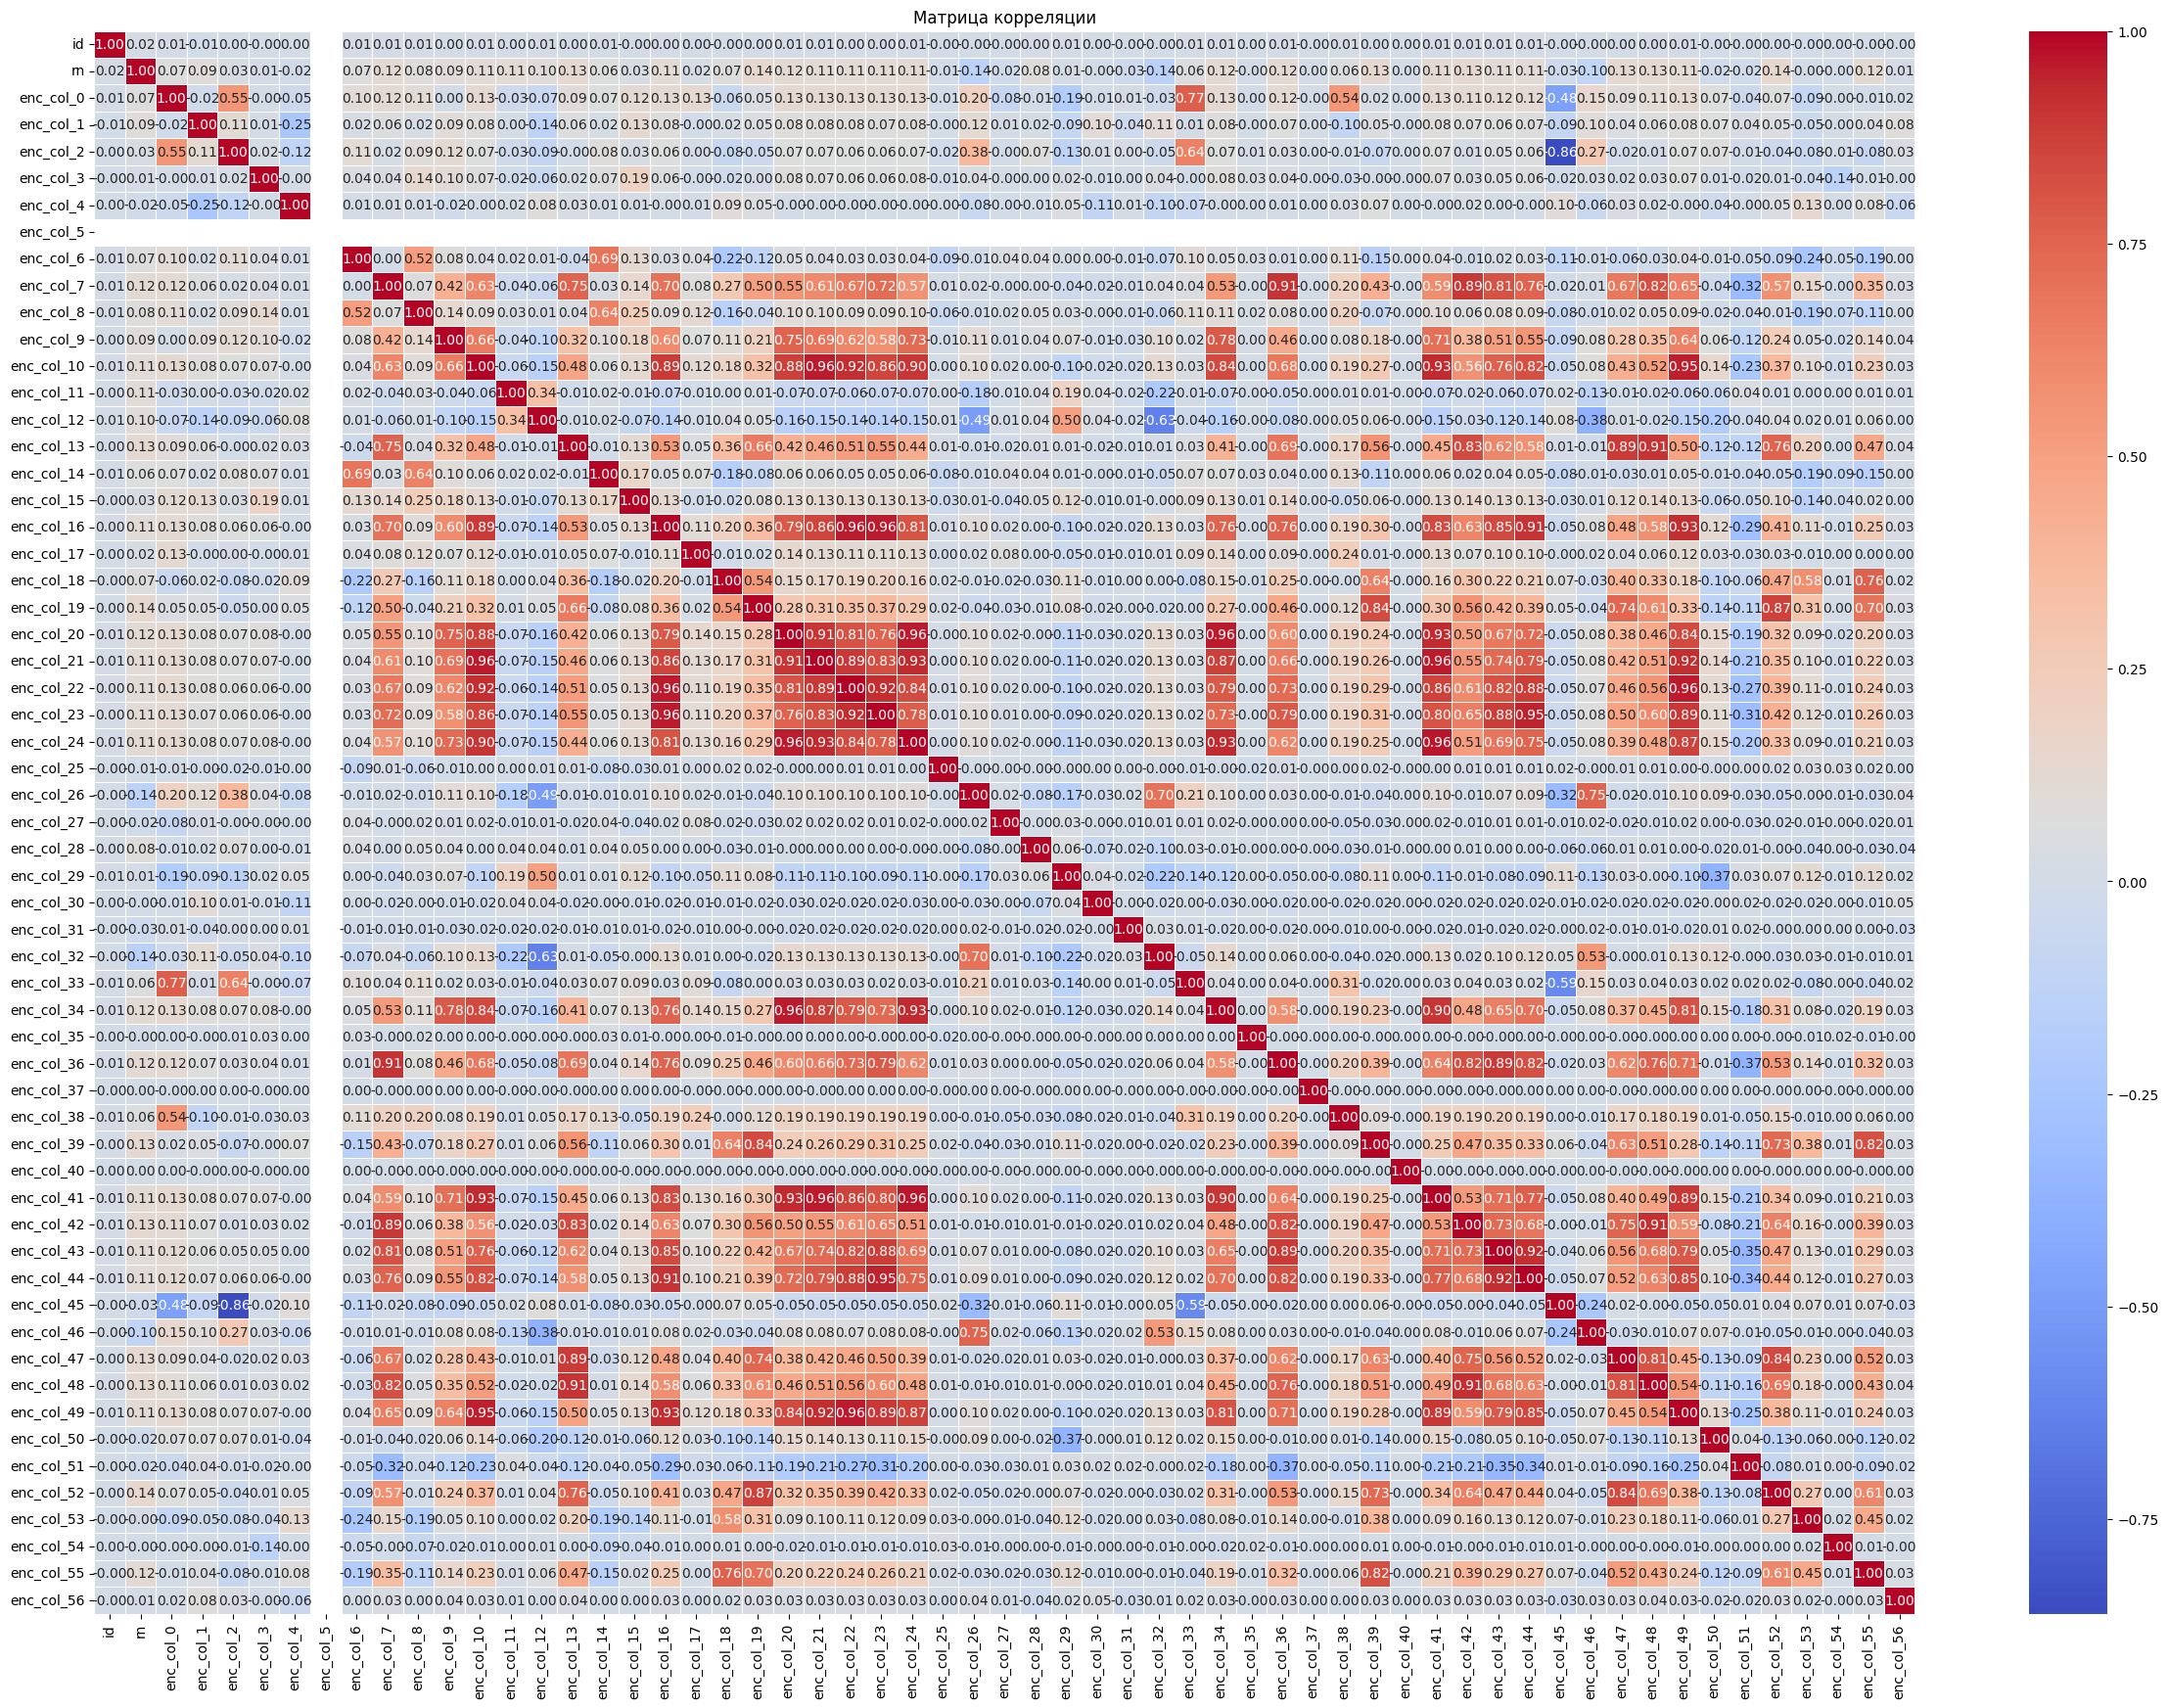

In [9]:
plt.figure(figsize=(30, 21))
sns.heatmap(corr_matrix_name['train_data_0.pq'], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

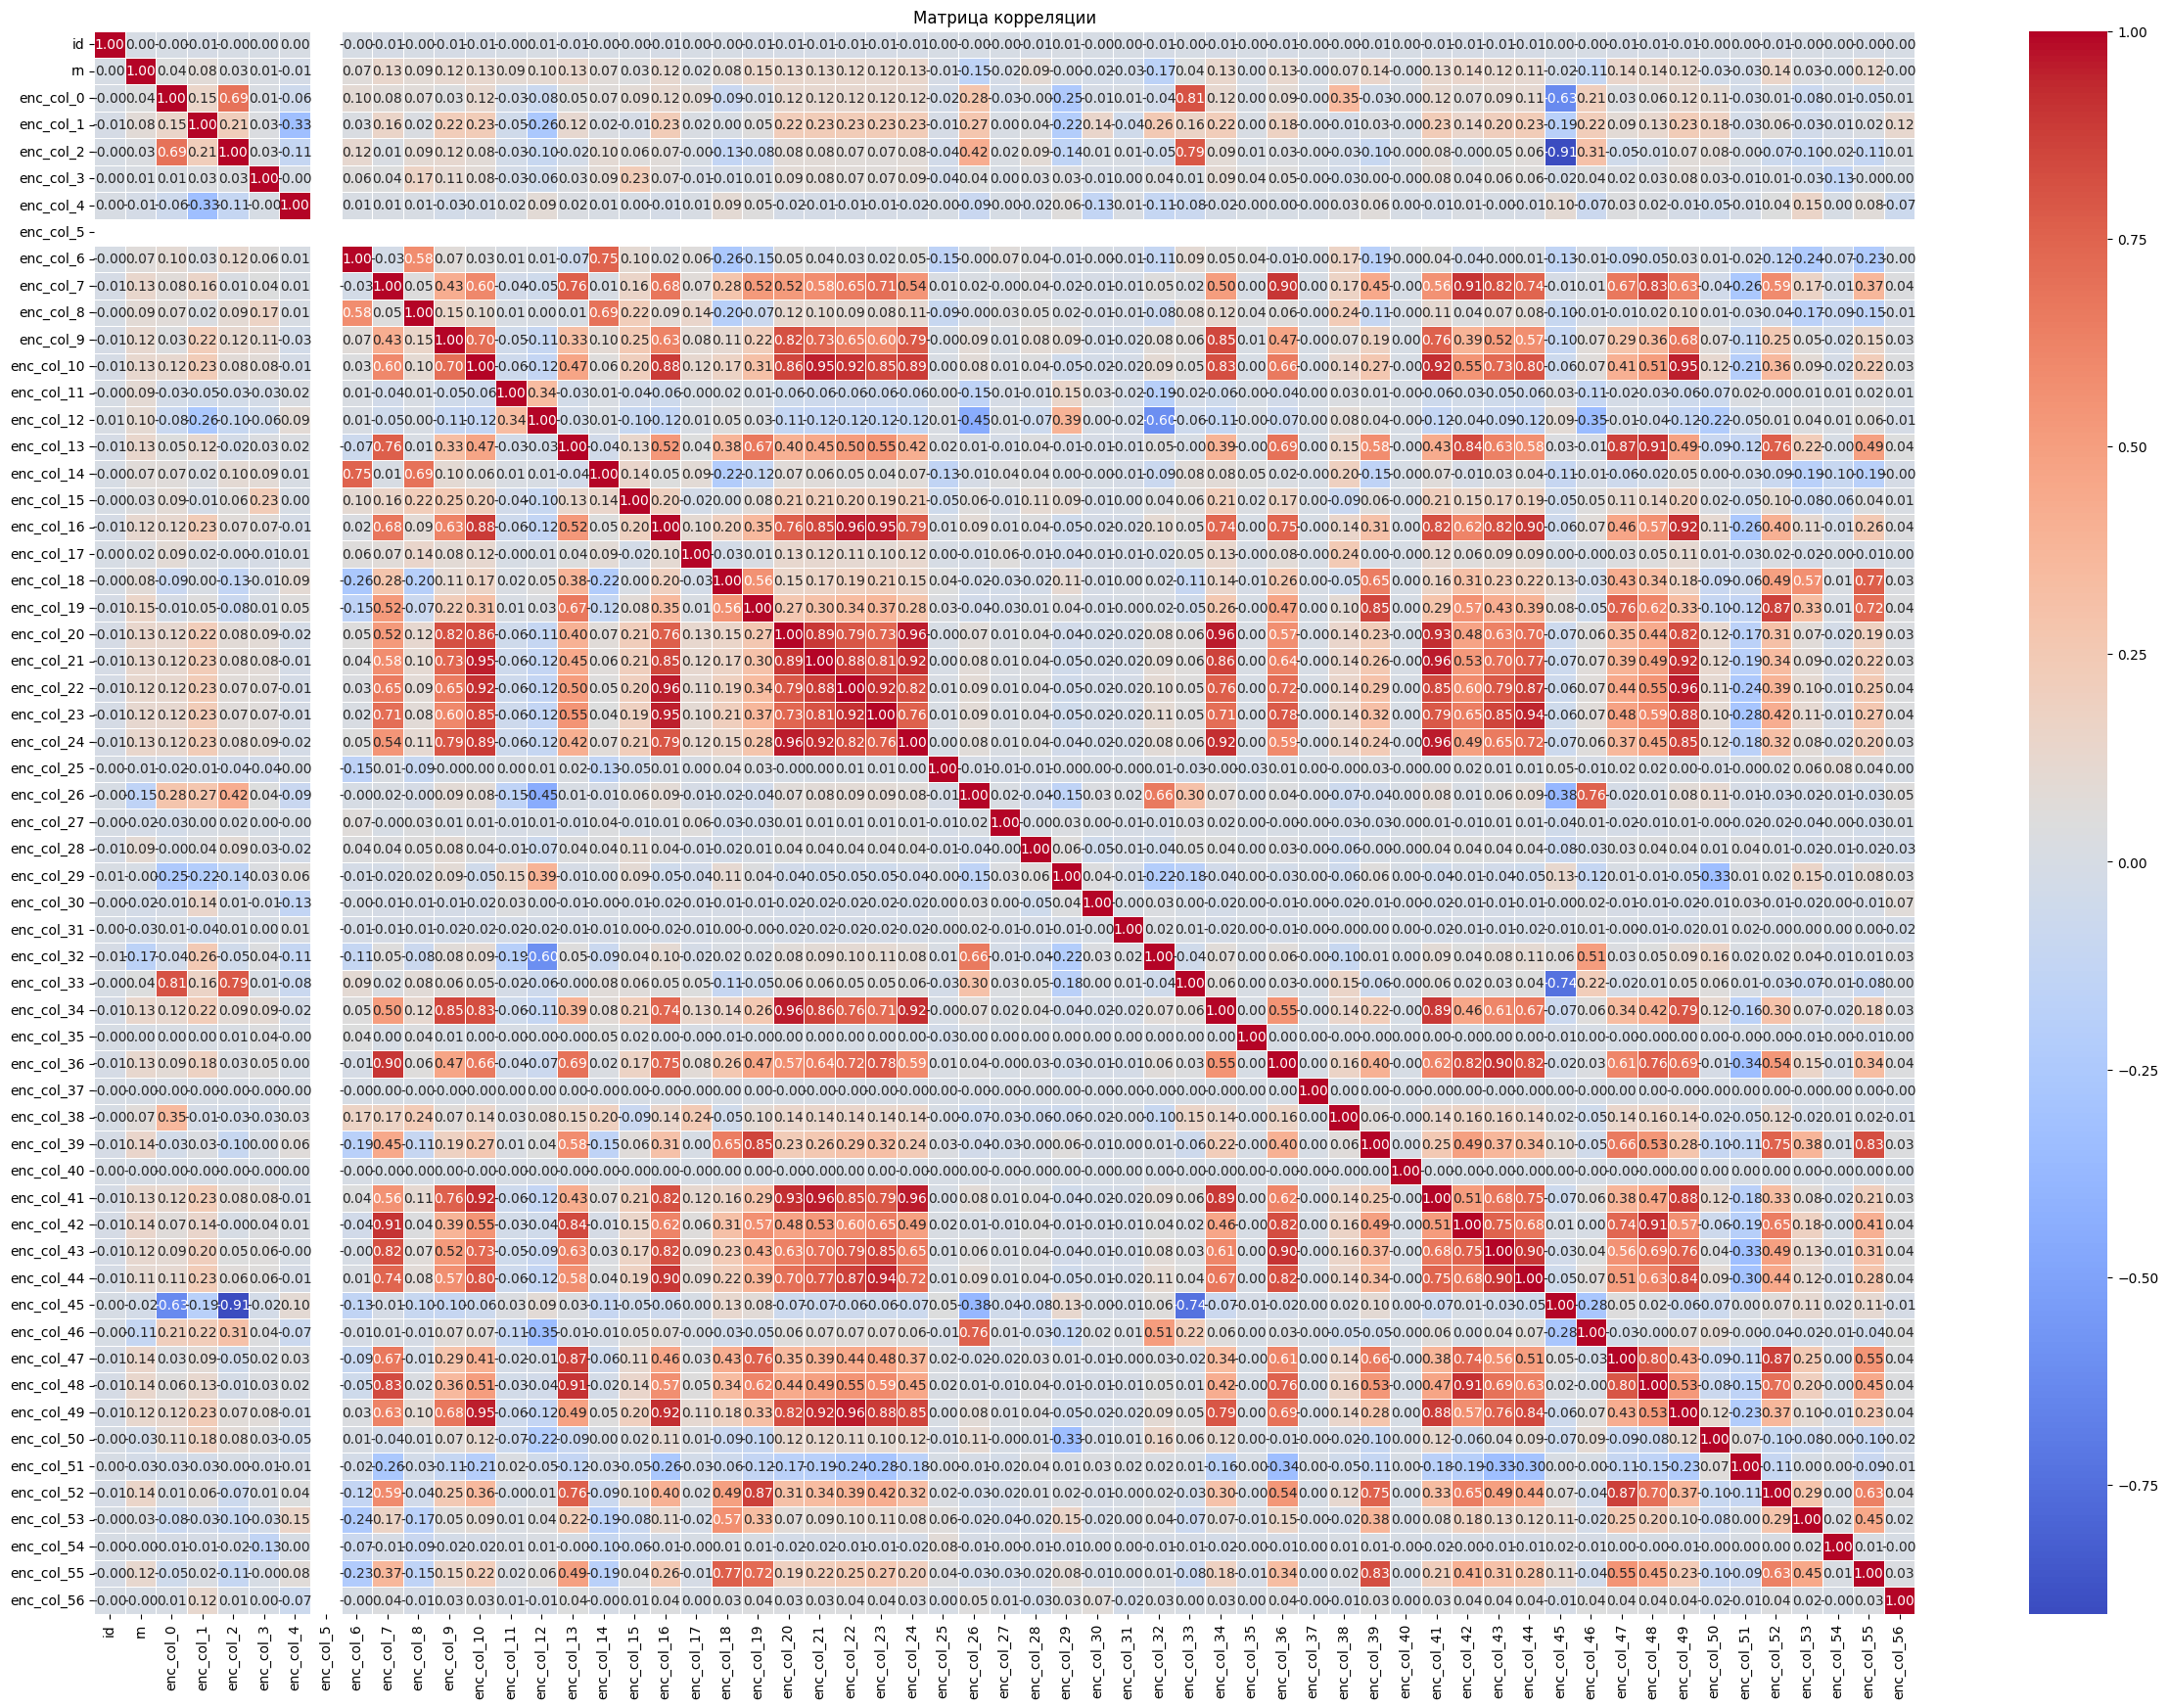

In [10]:
plt.figure(figsize=(30, 21))
sns.heatmap(corr_matrix_name['train_data_7.pq'], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

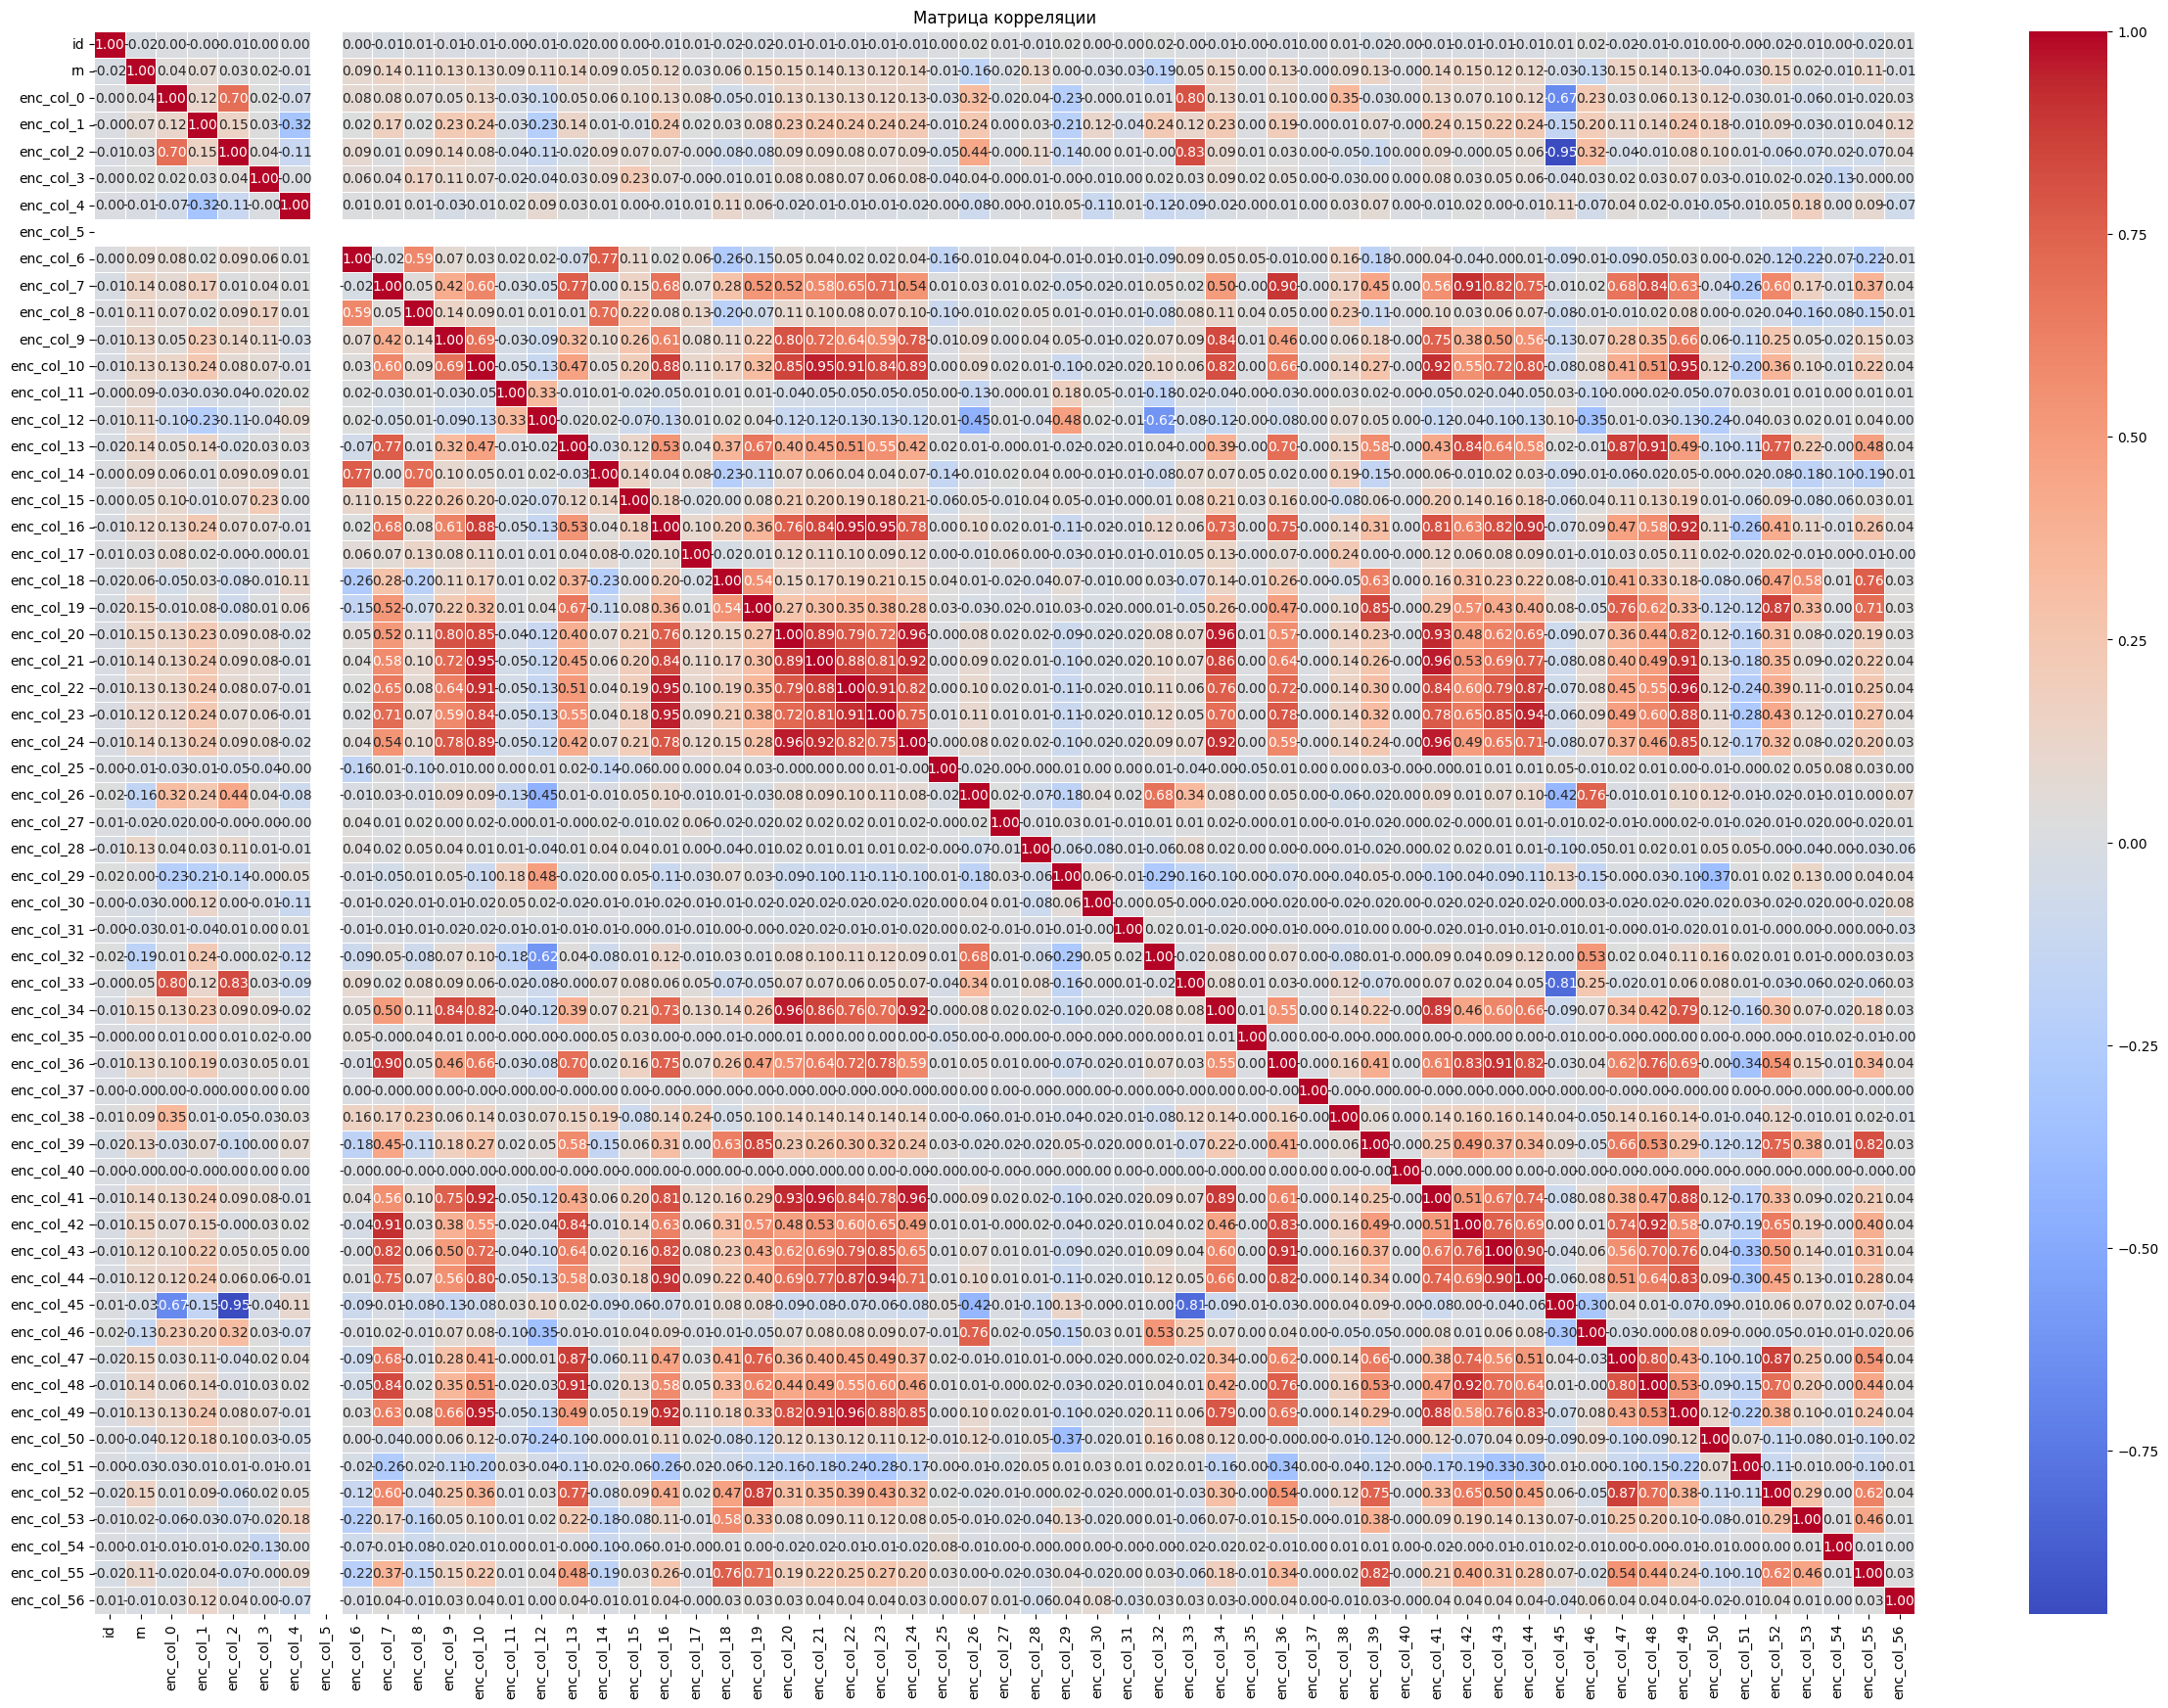

In [11]:
plt.figure(figsize=(30, 21))
sns.heatmap(corr_matrix_name['train_data_11.pq'], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

#### Анализ корреляционных матриц

Если очень бегло визуально оценить, формируются класстеры коррелированных признаков в одних и тех же местах, от которых необходимо избавиться
(в идеале провести более детальный анализ)
Признак 5 вообще не несет никакой смысловой нагрузки

Признаки для удаления: 
- enc_col_5 - никакой информации

- enc_col_20 - класстер 
- enc_col_21
- enc_col_22
- enc_col_23
- enc_col_24

- enc_col_41 - кластер
- enc_col_42
- enc_col_43
- enc_col_44

- enc_col_47 - кластер
- enc_col_48
- enc_col_49

Из данных признаков оставим: 
- enc_col_23
- enc_col_42
- enc_col_49

In [6]:
# Признаки для удаления
feateru_for_delete = [
    "enc_col_5",
    "enc_col_20", 
    "enc_col_21",
    "enc_col_22",
    "enc_col_24",
    "enc_col_41",
    "enc_col_43",
    "enc_col_44",
    "enc_col_47",
    "enc_col_48"
]

### Определение дисбаланса классов 

Присутствует очень сильный дисбаланс классов

На начальном этапе использовать взвешенное определение

Позже попробовать делать подвыборки 

In [7]:
target_train = pd.read_csv(TRAIN_TARGET)

In [8]:
target_train['target'].value_counts() #Очень сильный дисбанас классов

target
0    2893558
1     106442
Name: count, dtype: int64

In [9]:
target_train.groupby('target')['id'].count()

target
0    2893558
1     106442
Name: id, dtype: int64

### Определение длинн историй

In [10]:
idx_to_hisLen = pd.concat(idx_to_hisLen, ignore_index=True)

In [11]:
idx_to_hisLen.shape #Получили ровно 3kk, как и должно быть

(3000000,)

In [12]:
idx_to_hisLen

0          10
1          14
2           3
3          15
4           1
           ..
2999995    14
2999996     5
2999997    14
2999998     7
2999999    15
Name: rn, Length: 3000000, dtype: int64

#### построим диагамму распределения длинн

Есть истории, различной длинны, на начальном этапе не обратим на это внимание, при формировании обучающей и валидационной выборки

8006 клиентов, которые имею историю взаимодействия больше 30

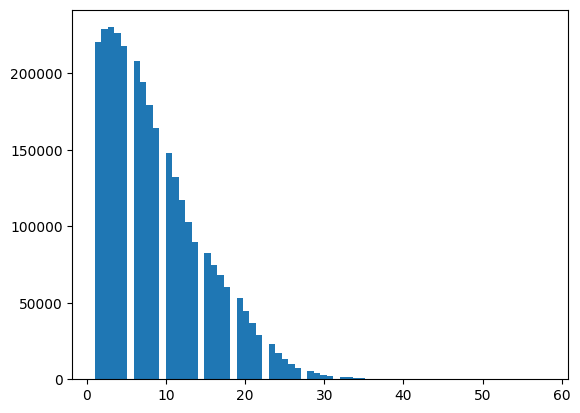

In [13]:
plt.hist(idx_to_hisLen, bins=70)
plt.show() 

In [14]:
idx_to_hisLen = idx_to_hisLen.reset_index()
idx_to_hisLen.columns = ['id', 'rn_len']

In [15]:
idx_to_hisLen

id  rn_len
0              0      10
1              1      14
2              2       3
3              3      15
4              4       1
...          ...     ...
2999995  2999995      14
2999996  2999996       5
2999997  2999997      14
2999998  2999998       7
2999999  2999999      15

[3000000 rows x 2 columns]

In [16]:
idx_to_hisLen[idx_to_hisLen > 30]

id  rn_len
0              NaN     NaN
1              NaN     NaN
2              NaN     NaN
3              NaN     NaN
4              NaN     NaN
...            ...     ...
2999995  2999995.0     NaN
2999996  2999996.0     NaN
2999997  2999997.0     NaN
2999998  2999998.0     NaN
2999999  2999999.0     NaN

[3000000 rows x 2 columns]

In [17]:
join_data_info = pd.merge(idx_to_hisLen, target_train, on="id")

In [18]:
join_data_info #DF с общей информацией - ID, длинна истории, таргет

id  rn_len  target
0              0      10       0
1              1      14       0
2              2       3       0
3              3      15       0
4              4       1       0
...          ...     ...     ...
2999995  2999995      14       0
2999996  2999996       5       0
2999997  2999997      14       0
2999998  2999998       7       0
2999999  2999999      15       0

[3000000 rows x 3 columns]

#### Сохраним, для дальнейшего анализа

In [19]:
join_data_info.to_csv("info_len_taget.csv")

### построим распределение длинн взаимодействий в зависимости от таргета

In [44]:
sub_data_hisLen_0 = join_data_info[join_data_info['target'] == 0]
sub_data_hisLen_1 = join_data_info[join_data_info['target'] == 1]

print(
    sub_data_hisLen_0.shape,
    sub_data_hisLen_1.shape
)

(2893558, 3) (106442, 3)


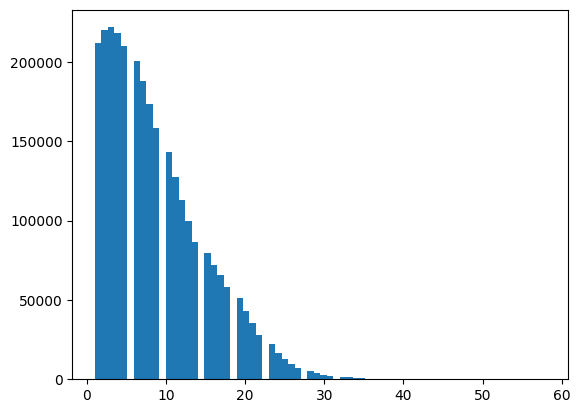

In [ ]:
# Для класса 0
plt.hist(sub_data_hisLen_0['rn_len'], bins=70)
plt.show() 

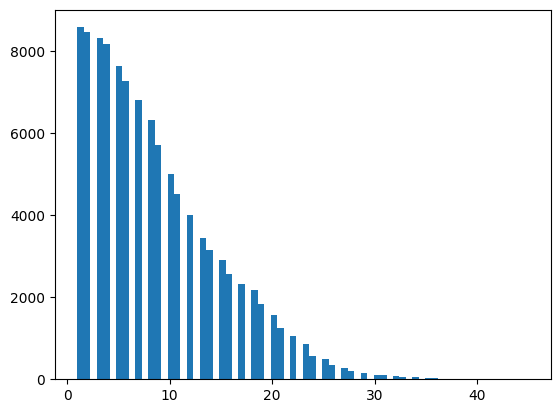

In [ ]:
# Для класса 1
plt.hist(sub_data_hisLen_1['rn_len'], bins=70)
plt.show() 

Примерно одинаково, но необходим более детальный анализ

### Просмотрим типы данных и пропуски, если есть

In [48]:
for filename in all_files_data:
    tmp_df = pd.read_parquet(f'{TRAIN_DATA_DIR}/{filename}')

    print(
        filename,
        tmp_df.info(),
        "----------------",
        sep="\n"
    )

# Все инты, занимает примерно 1GB, следовательно при создании dataset для обучения нужно учиывать, чтобы загружать только 1 файл

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 59 columns):
 #   Column      Dtype
---  ------      -----
 0   id          int64
 1   rn          int64
 2   enc_col_0   int64
 3   enc_col_1   int64
 4   enc_col_2   int64
 5   enc_col_3   int64
 6   enc_col_4   int64
 7   enc_col_5   int64
 8   enc_col_6   int64
 9   enc_col_7   int64
 10  enc_col_8   int64
 11  enc_col_9   int64
 12  enc_col_10  int64
 13  enc_col_11  int64
 14  enc_col_12  int64
 15  enc_col_13  int64
 16  enc_col_14  int64
 17  enc_col_15  int64
 18  enc_col_16  int64
 19  enc_col_17  int64
 20  enc_col_18  int64
 21  enc_col_19  int64
 22  enc_col_20  int64
 23  enc_col_21  int64
 24  enc_col_22  int64
 25  enc_col_23  int64
 26  enc_col_24  int64
 27  enc_col_25  int64
 28  enc_col_26  int64
 29  enc_col_27  int64
 30  enc_col_28  int64
 31  enc_col_29  int64
 32  enc_col_30  int64
 33  enc_col_31  int64
 34  enc_col_32  int64
 35  enc_col_33  int64
 36  enc_col_